In [10]:
"""
Deep Q-Network Q(a, s)
-----------------------
TD Learning, Off-Policy, e-Greedy Exploration (GLIE).
Q(S, A) <- Q(S, A) + alpha * (R + lambda * Q(newS, newA) - Q(S, A))
delta_w = R + lambda * Q(newS, newA)
See David Silver RL Tutorial Lecture 5 - Q-Learning for more details.
Reference
----------
original paper: https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
EN: https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0#.5m3361vlw
CN: https://zhuanlan.zhihu.com/p/25710327
Note: Policy Network has been proved to be better than Q-Learning, see tutorial_atari_pong.py
Environment
-----------
# The FrozenLake v0 environment
https://gym.openai.com/envs/FrozenLake-v0
The agent controls the movement of a character in a grid world. Some tiles of
the grid are walkable, and others lead to the agent falling into the water.
Additionally, the movement direction of the agent is uncertain and only partially
depends on the chosen direction. The agent is rewarded for finding a walkable
path to a goal tile.
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
The episode ends when you reach the goal or fall in a hole. You receive a reward
of 1 if you reach the goal, and zero otherwise.
Prerequisites
--------------
tensorflow>=2.0.0a0
tensorlayer>=2.0.0
To run
-------
python tutorial_DQN.py --train/test
"""


'\nDeep Q-Network Q(a, s)\n-----------------------\nTD Learning, Off-Policy, e-Greedy Exploration (GLIE).\nQ(S, A) <- Q(S, A) + alpha * (R + lambda * Q(newS, newA) - Q(S, A))\ndelta_w = R + lambda * Q(newS, newA)\nSee David Silver RL Tutorial Lecture 5 - Q-Learning for more details.\nReference\n----------\noriginal paper: https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf\nEN: https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0#.5m3361vlw\nCN: https://zhuanlan.zhihu.com/p/25710327\nNote: Policy Network has been proved to be better than Q-Learning, see tutorial_atari_pong.py\nEnvironment\n-----------\n# The FrozenLake v0 environment\nhttps://gym.openai.com/envs/FrozenLake-v0\nThe agent controls the movement of a character in a grid world. Some tiles of\nthe grid are walkable, and others lead to the agent falling into the water.\nAdditionally, the movement direction of the agent 

In [6]:
import os
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from IPython.display import clear_output

tl.logging.set_verbosity(tl.logging.DEBUG)

class DQNAgent():
    def __init__(self,
                  env=None,
                  discount_factor=0.90,
                  max_eps=1,
                  min_eps=0.1,
                  num_episodes=10000,
                  eps_decay=0.999993,
                  learning_rate=0.01
                  ):
        self.discount_factor = discount_factor
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.num_episodes = num_episodes
        self.rList = [] #Record reward
        self.alg_name = 'DQN'
        self.goal_reached_n = 0  # count the number of times the goal is reached
        self.eps = self.max_eps
        self.eps_decay = eps_decay
        self.q_table = np.zeros((100, 4))
        self.goal_position = np.array(np.where(env.desc == b'G')).flatten()
        self.position = np.array(np.where(env.desc == b'S')).flatten()
        self.max_distance = np.abs(self.position - self.goal_position).sum()
        self.env = env
        self.learning_rate = learning_rate

        self.qnetwork = self.get_model([None, 100])
        self.qnetwork.train()

        self.train_weights = self.qnetwork.trainable_weights
        self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)



    ##################### DQN ##########################
    def to_one_hot(self, i, n_classes=None):
        a = np.zeros(n_classes, 'uint8')
        a[i] = 1
        return a


    ## Define Q-network q(a,s) that ouput the rewards of 4 actions by given state, i.e. Action-Value Function.
    # encoding for state: 10x10 grid can be represented by one-hot vector with 100 integers.
    def get_model(self, inputs_shape):
        ni = tl.layers.Input(inputs_shape, name='observation')
        nn = tl.layers.Dense(4, act=None, W_init=tf.random_uniform_initializer(0, 0.01), b_init=None, name='q_a_s')(ni)
        return tl.models.Model(inputs=ni, outputs=nn)
    
    def save_ckpt(self, model):  # save trained weights
        path = os.path.join('model', '_'.join([self.alg_name, self.learning_rate, self.discount_factor]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'dqn_model.hdf5'), model)

        with open(os.path.join(path, 'env_desc.txt'), 'w') as f:
            f.write(str(self.env.desc))


    def load_ckpt(self, model):  # load trained weights
        path = os.path.join('model', '_'.join([self.alg_name, self.learning_rate, self.discount_factor]))
        tl.files.save_weights_to_hdf5(os.path.join(path, 'dqn_model.hdf5'), model)


    def train(self):
        flattened_map = self.env.desc.flatten()
        all_episode_reward = []
        for i in range(self.num_episodes):
            visited = set()
            ## Reset environment and get first new observation
            s = self.env.reset()[0]  # observation is state
            rAll = 0
            while True:
                ## Choose an action by greedily (with e chance of random action) from the Q-network
                allQ = self.qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32)).numpy()
                self.q_table[s] = allQ
                a = np.argmax(allQ, 1)

                ## e-Greedy Exploration !!! sample random action
                if np.random.rand(1) < self.eps:
                    a[0] = self.env.action_space.sample()
                ## Get new state and reward from self.ironment
                next_state, r, d, _, _ = self.env.step(a[0])

                # if flattened_map[next_state] == b'G':
                #     self.goal_reached_n += 1
                self.position = np.array([next_state // 10, next_state % 10])
                
                manhattan_distance = np.abs(self.position - self.goal_position).sum()
                dist_reward = manhattan_distance / self.max_distance

                if next_state in visited:
                    r = -10
                elif next_state == s and not d:
                    r = -10
                elif flattened_map[next_state] == b'H':
                    r = -50
                elif flattened_map[next_state] == b'G':
                    r = 100
                    self.goal_reached_n += 1
                elif flattened_map[next_state] == b'F':
                    r = -1

                if r < 0:
                    r *= dist_reward
                
                ## Obtain the Q' values by feeding the new state through our network
                q1 = self.qnetwork(np.asarray([self.to_one_hot(next_state, 100)], dtype=np.float32)).numpy()
                ## Obtain maxQ' and set our target value for chosen action.
                max_q1 = np.max(q1)  # in Q-Learning, policy is greedy, so we use "max" to select the next action.
                targetQ = allQ
                targetQ[0, a[0]] = r + self.discount_factor * max_q1
                ## Train network using target and predicted Q values
                # it is not real target Q value, it is just an estimation,
                # but check the Q-Learning update formula:
                #    Q'(s,a) <- Q(s,a) + alpha(r + lambd * maxQ(s',a') - Q(s, a))
                # minimizing |r + lambd * maxQ(s',a') - Q(s, a)|^2 equals to force Q'(s,a) ≈ Q(s,a)
                with tf.GradientTape() as tape:
                    _qvalues = self.qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32))
                    _loss = tl.cost.mean_squared_error(targetQ, _qvalues, is_mean=False)
                grad = tape.gradient(_loss, self.train_weights)
                self.optimizer.apply_gradients(zip(grad, self.train_weights))

                rAll += r
                s = next_state
                
                if s not in visited:
                    visited.add(s)
                ## Reduce chance of random action if an episode is done.
                if d == True:
                    if self.eps > self.min_eps:
                        self.eps *= self.eps_decay
                    break

            ## Note that, the rewards here with random action
            if i % 10000 == 0:
                print('Training  | Episode: {}/{}  | Episode Reward: {:.4f} | Epsilon: {:.4f} | Goal reached: {}' \
                        .format(i, self.num_episodes, rAll, self.eps, self.goal_reached_n))
            if i % 100000 == 0 :
                print(self.q_table)
            if i == 0:
                all_episode_reward.append(rAll)
            else:
                all_episode_reward.append(all_episode_reward[-1] * 0.9 + rAll * 0.1)

        self.save_ckpt(self.qnetwork)  # save model
        print(self.q_table)
        plt.plot(all_episode_reward)
        if not os.path.exists('image'):
            os.makedirs('image')
        plt.savefig(os.path.join('image', '_'.join([self.alg_name, self.learning_rate, self.discount_factor]) + '.png'))

    
    def test(self, qnetwork, num_episodes, env, t0):
        self.load_ckpt(qnetwork)  # load model
        for i in range(num_episodes):
            ## Reset environment and get first new observation
            s = env.reset()[0]  # observation is state, integer 0 ~ 15
            rAll = 0
            if self.render: env.render()
            for j in range(99):  # step index, maximum step is 99
                ## Choose an action by greedily (with e chance of random action) from the Q-network
                allQ = qnetwork(np.asarray([self.to_one_hot(s, 16)], dtype=np.float32)).numpy()
                a = np.argmax(allQ, 1)  # no epsilon, only greedy for testing

                ## Get new state and reward from environment
                s1, r, d, _ = env.step(a[0])
                rAll += r
                s = s1
                if self.render: env.render()
                ## Reduce chance of random action if an episode is done.
                if d: break

            print('Testing  | Episode: {}/{}  | Episode Reward: {:.4f} | Running Time: {:.4f}' \
                  .format(i, num_episodes, rAll, time.time() - t0))
            self.rList.append(rAll)
        print("Correct rate: " + str(sum(self.rList) / num_episodes * 100) + "%")


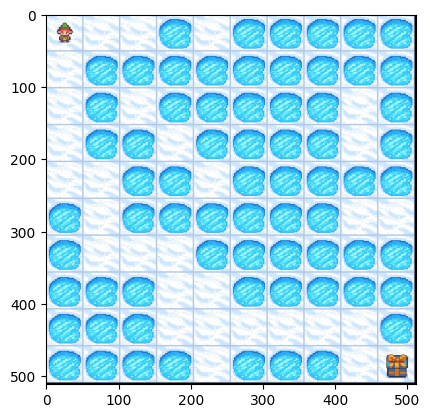

In [7]:
from gym.envs.toy_text.frozen_lake import generate_random_map

random_map = generate_random_map(size=10, p=0.3)    
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
display(plt.gcf())
clear_output(wait=True)

[TL] Input  observation: [None, 100]
[TL] Dense  q_a_s: 4 No Activation


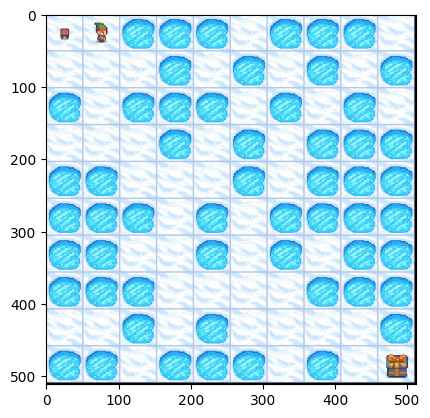

[[b'S' b'F' b'H' b'H' b'H' b'F' b'H' b'H' b'H' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'H' b'F' b'H' b'F' b'H']
 [b'H' b'F' b'H' b'H' b'H' b'F' b'H' b'F' b'H' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'H' b'F' b'H' b'H' b'H']
 [b'H' b'H' b'F' b'F' b'F' b'H' b'F' b'H' b'H' b'H']
 [b'H' b'H' b'H' b'F' b'H' b'F' b'H' b'H' b'H' b'H']
 [b'H' b'H' b'F' b'F' b'H' b'F' b'H' b'F' b'H' b'H']
 [b'H' b'H' b'H' b'F' b'F' b'F' b'F' b'H' b'H' b'H']
 [b'F' b'F' b'H' b'F' b'H' b'F' b'F' b'F' b'F' b'H']
 [b'H' b'H' b'F' b'H' b'H' b'H' b'F' b'H' b'F' b'G']]


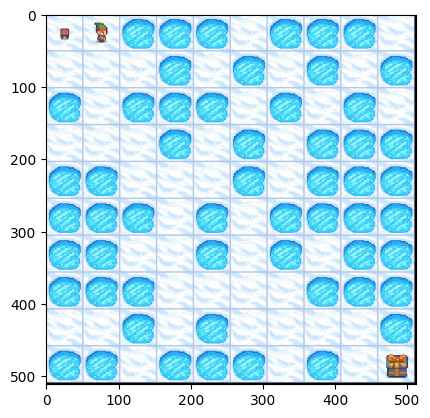

In [15]:

agent = DQNAgent(num_episodes=1_000_000, eps_decay=0.9999975, discount_factor=0.7, env=env)

plt.imshow(env.render())
display(plt.gcf())

print(env.desc)


In [14]:
agent.train()

c:\Users\kuba\OneDrive\Pulpit\studia\year 5\applied ai\assessment1\CS5079_AppliedAI\.venv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Training  | Episode: 0/1000000  | Episode Reward: -43.0000 | Epsilon: 1.0000 | Goal reached: 0
[[ 0.00339932  0.00184553  0.00616447  0.00969839]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.00829121  0.00758235  0.00924638 -0.19696859]
 [ 0.00903523  0.00648355  0.00089837  0.00658281]
 [ 0.00964844  0.00181617  0.00991539  0.00174959]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.         

KeyboardInterrupt: 

In [ ]:
agent.goal_reached_n

In [ ]:
agent.load_ckpt(agent.qnetwork)  # load model
for i in range(agent.num_episodes):
    ## Reset environment and get first new observation
    s = env.reset()[0]  # observation is state
    rAll = 0
    for j in range(99):  # step index, maximum step is 99
        ## Choose an action by greedily (with e chance of random action) from the Q-network
        allQ = agent.qnetwork(np.asarray([agent.to_one_hot(s, 100)], dtype=np.float32)).numpy()
        a = np.argmax(allQ, 1)  # no epsilon, only greedy for testing

        ## Get new state and reward from environment
        s1, r, d, _, _ = env.step(a[0])
        rAll += r
        s = s1
        ## Reduce chance of random action if an episode is done.
        if d: break

    print('Testing  | Episode: {}/{}  | Episode Reward: {:.4f}' \
            .format(i, agent.num_episodes, rAll))
    agent.rList.append(rAll)
print("Correct rate: " + str(sum(agent.rList) / agent.num_episodes * 100) + "%")

In [ ]:
agent.qnetwork.trainable_weights

In [ ]:
np.printoptions(suppress=True)
init_weights = np.hstack((np.random.uniform(0, 0.01, (100, 1)), 
                        np.random.uniform(0.5, 0.51, (100, 1)), 
                        np.random.uniform(0.5, 0.51, (100, 1)), 
                        np.random.uniform(0, 0.01, (100, 1))))

# lefts = np.array()
# rights = np.array()
# downs = np.array()
# ups = np.array()

# goal_position = [9, 9]

# for state in range(100):
#     position = np.array([state // 10, state % 10])

#     manhattan_distance = np.abs(position - goal_position).sum()


# self.position = np.array([next_state // 10, next_state % 10])

# manhattan_distance = np.abs(self.position - self.goal_position).sum()
# dist_reward = manhattan_distance / self.max_distance


# print(init_weights)

[[3.92174213e-03 5.01733404e-01 5.06213779e-01 4.18353222e-04]
 [8.50802062e-03 5.04086759e-01 5.01828308e-01 4.11676990e-03]
 [3.39397145e-05 5.04173760e-01 5.07582303e-01 4.61516052e-03]
 [6.85204496e-03 5.09407392e-01 5.03914919e-01 3.10427677e-03]
 [1.62543444e-03 5.01652416e-01 5.00020837e-01 2.04897670e-03]
 [7.59144063e-03 5.08542536e-01 5.05098403e-01 8.16101330e-03]
 [3.87569268e-03 5.08323699e-01 5.02269043e-01 7.04792290e-03]
 [5.04126210e-03 5.01886622e-01 5.08572906e-01 2.20001732e-03]
 [6.79531167e-03 5.02837772e-01 5.09954923e-01 7.27487839e-03]
 [7.57513381e-03 5.02428869e-01 5.07121709e-01 7.34088100e-03]
 [1.39259785e-03 5.00170836e-01 5.03095088e-01 4.49984187e-04]
 [2.90267441e-03 5.09994759e-01 5.02826680e-01 1.26483357e-03]
 [2.43170098e-04 5.04193105e-01 5.08277878e-01 1.15776674e-03]
 [2.75121476e-03 5.01885705e-01 5.09634249e-01 2.03639522e-03]
 [7.74631922e-03 5.07431753e-01 5.02320916e-01 1.16665463e-03]
 [6.49848411e-03 5.02217692e-01 5.02893771e-01 4.934552

In [21]:
tf.constant_initializer(init_weights)

In [2]:
a = [1,2,3,4]
a[1:3]

[2, 3]

In [12]:
env.observation_space

Discrete(100)